1) Multi-regression output problem --> predict two labels: longitude and latitude

2) Re-write problem as multi-class problem through clustering
To define the classes, the last points per trip from the training data will be divided into clusters. When we have a large enough number of clusters, the clusters should be small enough to have their points close to their centroids. 

K-Means is a good approach as it minimizes the sum of squared distances within the cluster. Also it scales well to a large number of clusters. 

So the approach then predicts: **Probability of final destination of a trip being located in a specific cluster**

Steps:
- Get optimal number of clusters with help of interia
- Generate clusters with K-Means for each trip in training data
- Predict cluster for each trip in testing data
- Get centroids for each cluster 
- Calculate distance from points in cluster to centroid to evaluate

In [62]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import awswrangler as wr
import random
from sklearn.cluster import KMeans
import dask.array as da
from dask_ml import cluster
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import geojson

In [63]:
is_sagemaker_notebook = False

In [64]:
if is_sagemaker_notebook:
    prefix = "/home/ec2-user/SageMaker"
else:
    prefix = "/Users/Q619505/PycharmProjects/personal-projects/taxi-destination-prediction"

utils_path = os.path.join(f'{prefix}/src/utils/')
pp_path = os.path.join(f'{prefix}/src/preprocessing')

if utils_path not in sys.path:
    sys.path.append(utils_path)

if pp_path not in sys.path:
    sys.path.append(pp_path)

In [65]:
from utils import *
from geo_spatial import convert_polyline_to_geojson_format, extract_lat_lon

In [66]:
test_data = pd.read_csv(f'{prefix}/data/processed/test_data.csv')
train_data = pd.read_csv(f'{prefix}/data/processed/train_data.csv')

In [67]:
train_data = convert_polyline_to_geojson_format(data=train_data, name_column='dest_point')
test_data = convert_polyline_to_geojson_format(data=test_data, name_column='dest_point')

In [68]:
train_data = extract_lat_lon(train_data,'dest_point')
test_data = extract_lat_lon(test_data,'dest_point')

In [69]:
X = np.vstack(train_data.dest_point)
# transform destintion point to dask format
X_da = da.from_array(X)

- Inertia/sum of squared distance shows still significant reduction for 4000 clusters, therefore choose n_clusters = 4000
- Due to high execution time more iterations are not considered

In [70]:
#inertia_per_k = [(k, KMeans(n_clusters=k, init='k-means++', verbose=True, random_state=1).fit(X_da).inertia_)
#  for k in range(1000,5000,1000)]

One iteration is sufficient as single points need to be clustered, the nature of the data already provides the clusters

In [71]:
random.seed(5)

In [72]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clustering', KMeans(n_clusters = 4000,
                                       init ='k-means++',
                                       n_init = 1, 
                                       verbose=True,
                                       random_state=1
                                      )
                 )])

In [73]:
cluster_label = pipe.fit_predict(X_da)

/Users/Q619505/Library/Caches/pypoetry/virtualenvs/taxi-destination-prediction-tbwwnVrE-py3.11/lib/python3.11/site-packages/dask/array/core.py:1763: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Initialization complete
Iteration 0, inertia 529.5985395506448.
Iteration 1, inertia 438.582868275159.
Iteration 2, inertia 425.6354223671848.
Iteration 3, inertia 420.60457060551187.
Iteration 4, inertia 417.77570121650945.
Iteration 5, inertia 415.9251524463911.
Iteration 6, inertia 414.5744781369845.
Iteration 7, inertia 413.60478521315855.
Iteration 8, inertia 412.7660168441035.
Iteration 9, inertia 412.1095814775065.
Iteration 10, inertia 411.6326172531498.
Iteration 11, inertia 411.32085063333193.
Iteration 12, inertia 411.06385850802155.
Iteration 13, inertia 410.8394471576984.
Iteration 14, inertia 410.6099452473617.
Iteration 15, inertia 410.38997217226665.
Iteration 16, inertia 410.2160098079303.
Iteration 17, inertia 410.0825213961122.
Iteration 18, inertia 409.97407396348456.
Iteration 19, inertia 409.9035951417958.
Iteration 20, inertia 409.84391292053255.
Iteration 21, inertia 409.78356148564717.
Iteration 22, inertia 409.74562342283014.
Converged at iteration 22: center 

In [74]:
train_data['cluster_label']=cluster_label.reshape(-1,1)

In [75]:
centers_scaled = pipe[1].cluster_centers_

In [76]:
centers = pipe[0].inverse_transform(centers_scaled)

In [77]:
centers = pd.DataFrame(centers, columns=['center_lon','center_lat'])

In [78]:
centers = centers.reset_index()

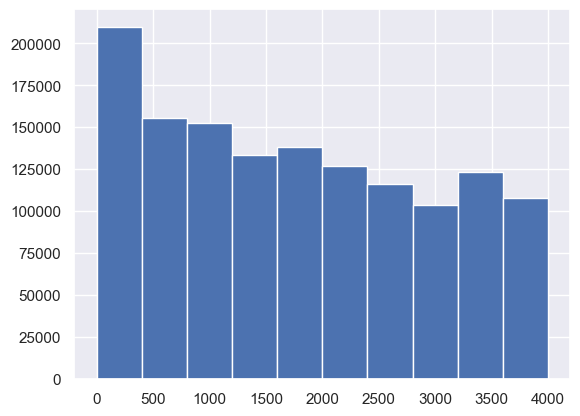

In [79]:
sns.set()
plt.hist(train_data.cluster_label)
plt.show()

In [82]:
X_test = np.vstack(test_data.dest_point)
X_da_test = da.from_array(np.array(X_test))
cluster_label = pipe.predict(X_da_test)
test_data['cluster_label']=cluster_label.reshape(-1,1)

/Users/Q619505/Library/Caches/pypoetry/virtualenvs/taxi-destination-prediction-tbwwnVrE-py3.11/lib/python3.11/site-packages/dask/array/core.py:1763: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


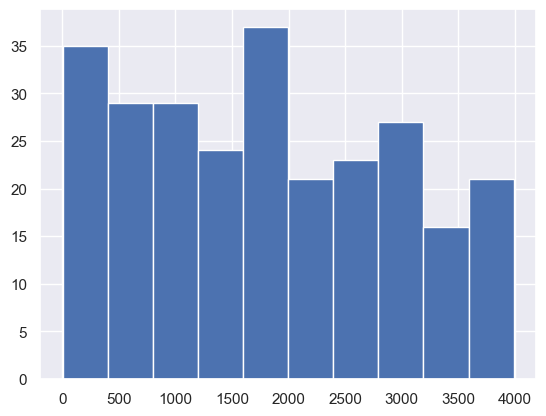

In [83]:
sns.set()
plt.hist(test_data.cluster_label)
plt.show()

In [84]:
assert(centers.index.max() == train_data.cluster_label.max())

In [85]:
test_data = pd.merge(test_data, centers[['index','center_lon','center_lat']], 
                           how='left', 
                           left_on='cluster_label',
                           right_on='index')
train_data = pd.merge(train_data, centers[['index','center_lon','center_lat']], 
                           how='left', 
                           left_on='cluster_label',
                           right_on='index')

In [86]:
n_cluster = train_data.cluster_label.nunique()

##### (!) Added only for EDA purposes

In [88]:
train_data = convert_polyline_to_geojson_format(data=train_data, name_column='start_point')

In [90]:
X_train = np.vstack(train_data.start_point)
X_da_train = da.from_array(np.array(X_train))
cluster_label = pipe.predict(X_da_train)
train_data['cluster_label_start']=cluster_label.reshape(-1,1)

/Users/Q619505/Library/Caches/pypoetry/virtualenvs/taxi-destination-prediction-tbwwnVrE-py3.11/lib/python3.11/site-packages/dask/array/core.py:1763: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [91]:
if is_sagemaker_notebook:
    aw.s3.to_parquet(df=train_data, path=f's3://think-tank-casestudy/preprocessed_data/n_cluster_{n_cluster}/train_data_clustered.parquet', dataset=True, partition_cols=['taxi_id'])
    aw.s3.to_parquet(df=test_data, path=f's3://think-tank-casestudy/preprocessed_data/n_cluster_{n_cluster}/test_data_clustered.parquet', dataset=True, partition_cols=['taxi_id'])

else:
    train_data.to_csv(f'{prefix}/data/processed/train_data_clustered.csv', header=True, index=False)
    test_data.to_csv(f'{prefix}/data/processed/test_data_clustered.csv', header=True, index=False)